# Binomial logistic regression with automatic cross-validated optimization

**Example using the logistic_auto function in the PyMLR module**

The **logistic_auto** function in the PyMLR module automatically finds the optimum set of cross-validated hyper-parameters and then outputs the fitted regression model and summary statistics using sklearn LogisticRegression with optuna.

This example shows how to check the cross-validation of the model with independent training and testing data subsets before fitting the final model with all of the data.

#### Example data set

This example uses the breast cancer data from scikit-learn which has a binomial response variable.

Before running this notebook, first install the PyMLR module in your environment, if it is not already installed, using the following line in the next cell:

In [1]:
# !pip install git+https://github.com/gjpelletier/PyMLR.git --upgrade

## Read X and y from the sklearn breast cancer data set

In [2]:
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True, as_frame=True)

## Split X and y into cross-validation train and test subsets

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train the model with the training data subset

In the next step, we will automatically find the best cross-validated hyper-parameters using optuna. Then we will fit the model using the training data with the best parameters. 

After this training step is completed, proceed to the next step to check how well the predictions from the training data match the predictions using the testing data. 

Running optuna to find best parameters, could take a few minutes, please wait...
Fitting LogisticRegression model with best parameters, please wait ...

LogisticRegression goodness of fit to training data in model_outputs['stats']:

| Statistic          |   LogisticRegression |
|:-------------------|---------------------:|
| mcfadden_pseudo_r2 |            0.842569  |
| accuracy           |            0.982418  |
| f1_score           |            0.986111  |
| precision          |            0.97931   |
| recall             |            0.993007  |
| log_loss           |            0.103859  |
| brier_score        |            0.0243073 |
| n_classes          |            2         |
| n_samples          |          455         |


Best-fit accuracy of CV test data: 0.9780

Done
Time elapsed: 38.53 sec



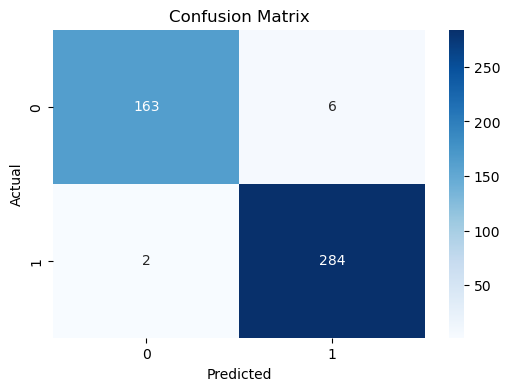

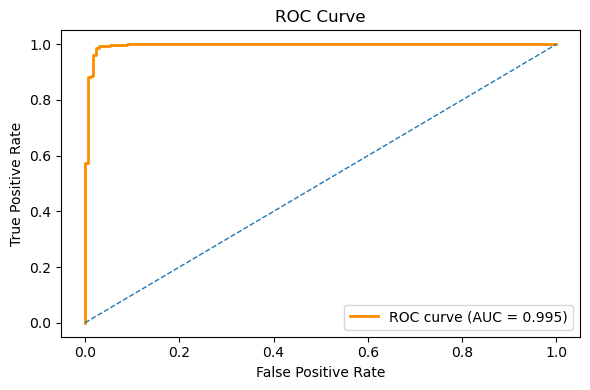

In [4]:
kwargs = {
    # user-specified params
    'random_state': 42,                 # random seed for reproducibility
    'n_trials': 50,                     # number of optuna trials
    # [min,max] model params that are optimized by optuna
    'C': [1e-4, 10],                    # Inverse of regularization strength
    # categorical model params optimized by optuna
    'solver': ['liblinear', 'lbfgs', 'saga'],   # optimization algorithm
    'penalty': ['l1', 'l2'],            # norm of the penalty
    # model extra_params that are optional user-specified
    'max_iter': 500,                    # max iterations for solver
    'n_jobs': -1                        # -1 to use all CPU cores
}    

from PyMLR import logistic_auto
train_model, train_output = logistic_auto(X_train, y_train, **kwargs)

## Test the model with the testing data subset

In the next step we will check how well the predictions from fitted model match samples from the testing data. To encode and standardize the testing data we will use the same encoder and scaler that were used to encode and standardize the training data, and the same optimal selected features from the training data, to avoid data leakage between the training and testing data.


LogisticRegression goodness of fit to testing data in results['stats']:

| Statistic          |   LogisticRegression |
|:-------------------|---------------------:|
| mcfadden_pseudo_r2 |            0.862144  |
| accuracy           |            0.982456  |
| f1_score           |            0.986111  |
| precision          |            0.972603  |
| recall             |            1         |
| log_loss           |            0.0913536 |
| brier_score        |            0.020871  |
| n_classes          |            2         |
| n_samples          |          114         |



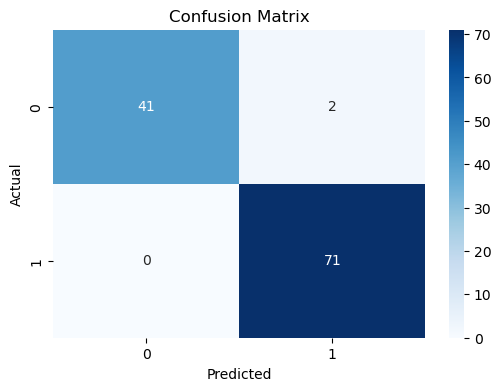

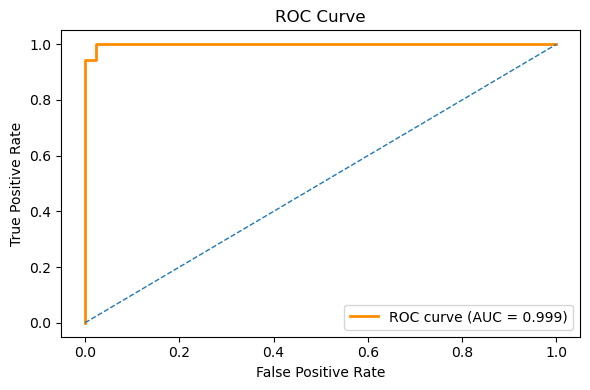

In [5]:
from PyMLR import test_model_logistic
test_output = test_model_logistic(train_model, X_test, y_test, 
    preprocess_result= train_output['preprocess_result'],
    selected_features= train_output['selected_features'])

## Final fit of the model using all of the X and y data

In the next step we will use the optimum hyperparameters and selected features from the training model and fit the model using all of the X and y data. First we will recalculate the standard scaler and encoder using  100% of the data, and then we will fit the model using 100% of the data.

Fitting LogisticRegression model with best parameters, please wait ...

LogisticRegression goodness of fit to training data in model_outputs['stats']:

| Statistic          |   LogisticRegression |
|:-------------------|---------------------:|
| mcfadden_pseudo_r2 |            0.856473  |
| accuracy           |            0.984183  |
| f1_score           |            0.987483  |
| precision          |            0.980663  |
| recall             |            0.994398  |
| log_loss           |            0.0947732 |
| brier_score        |            0.0223523 |
| n_classes          |            2         |
| n_samples          |          569         |

Done
Time elapsed: 0.29 sec



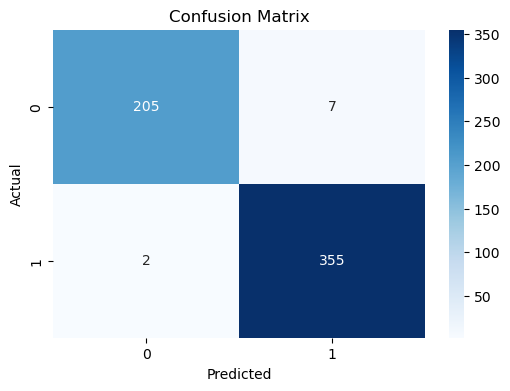

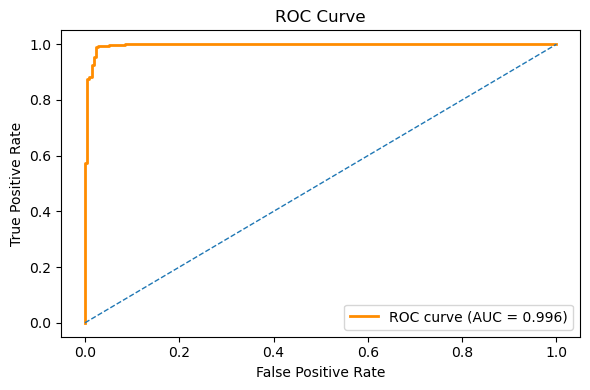

In [6]:
# step 1: recalculate the scaler and encoder using 100% of the data
from PyMLR import preprocess_train
preprocess_result_final = preprocess_train(X)

# step 2: final fit using 100% of the data, the updated scaler and encoder,
# and the hyperparamters/selected features from the training with 80% of the data
from PyMLR import logistic
final_model, final_output = logistic(X, y, 
    **train_output['best_params'],
    preprocess_result= preprocess_result_final,
    selected_features= train_output['selected_features'])

## Display the results of the hyperparameter optimization

The results of the optuna optimization study were saved in the previous step when the model was trained with the training data subset. The output dictionary that we called **train_output** in that step contains a key named **optuna_study** which contains the results of the optimized optuna study. 

In the next step we will use the **show_optuna** function of PyMLR to display the results of the optimized cross-validated optuna study to show the selected optimum values for the hyperparameters, the optimization history, and the relationships between the hyperparameters and their importance for the scoring criteria.

Best parameters:

C: 0.06299440839199755
solver: liblinear
penalty: l2
num_features: 27

Best score: 0.9780219780219781



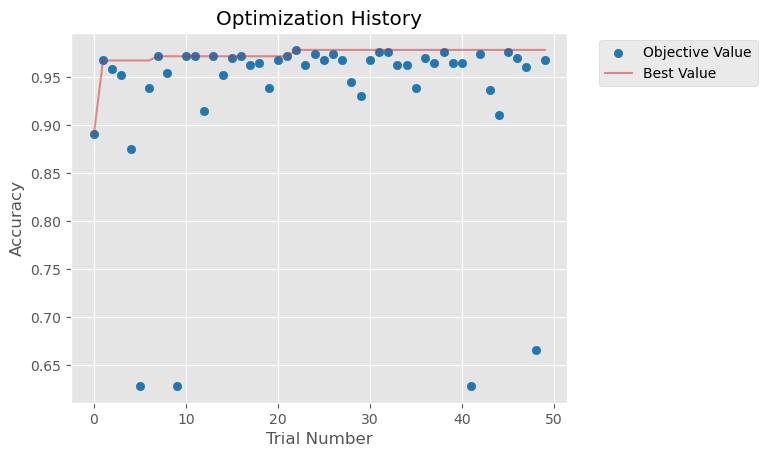

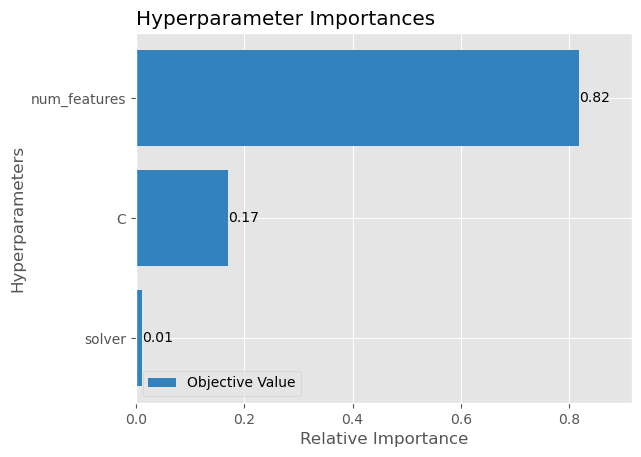

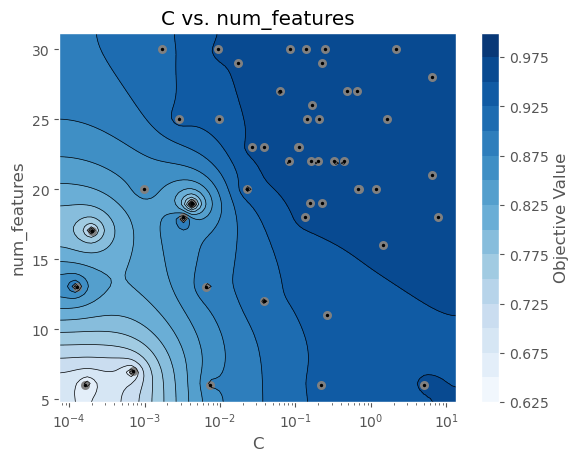

In [7]:
from PyMLR import show_optuna
show_optuna(train_output['optuna_study'])

## User instructions

In [8]:
help(logistic_auto)

Help on function logistic_auto in module PyMLR:

logistic_auto(X, y, **kwargs)
    Autocalibration of LogisticRegression hyperparameters
    Beta version

    by
    Greg Pelletier
    gjpelletier@gmail.com
    15-June-2025

    REQUIRED INPUTS (X and y should have same number of rows and
    only contain real numbers)
    X = dataframe or array of the candidate independent variables
        (as many columns of data as needed)
    y = dataframe or array of the dependent variable (one column of data)

    OPTIONAL KEYWORD ARGUMENTS
    **kwargs (optional keyword arguments):
        # general params that are user-specified
        n_trials= 50,             # Number of optuna trials
        preprocess= True,         # Apply OneHotEncoder and StandardScaler
        preprocess_result= None,  # dict of the following result from
                                  # preprocess_train if available:
                                  # - encoder          (OneHotEncoder)
                            